In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import cv2
from lxml import etree
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import datasets, models

from draw import show_img
from dataset import variable_shape_collate_fn
import transforms
from transforms import BoundingBoxFormatConvert,ToX1y1x2y2Abs, ToCxcywhRel, ToIaa, iaa_hsv_aug, iaa_random_crop, iaa_letterbox, \
                       IaaAugmentations, ToNp, IaaLetterbox, ToTensor, Compose
from boundingbox import bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh, \
                        bbox_xywh_to_cxcywh, bbox_xywh_to_x1y1x2y2, CoordinateType, FormatType, BoundingBoxConverter
    
from imgaug import augmenters as iaa

# Transforms and Augmentations

In [2]:
def getTransforms(dim, bbs_idx=np.arange(0,4),
                  coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=True):
    if aug:
        transform = Compose([ToX1y1x2y2Abs(CoordinateType.Relative, FormatType.cxcywh, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5)
                                              ]),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    else:
        transform = Compose([ToX1y1x2y2Abs(CoordinateType.Relative, FormatType.cxcywh, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    return transform

# Dataset

In [3]:
def get_xml_labels(xml_path):
    labels = OrderedDict()
    
    tree = etree.parse(xml_path)
    root = tree.getroot() 
    
    img_tags = root.xpath("image")

    for image in img_tags:
        img = image.get('name', None)
        labels[img] = []
        for box in image:
            cls = box.get('label', None)
            x1 = box.get('xtl', None)
            y1 = box.get('ytl', None)
            x2 = box.get('xbr', None)
            y2 = box.get('ybr', None)
            labels[img] += [{'cls' : cls, 
                             'x1'  : x1 ,
                             'y1'  : y1 ,
                             'x2'  : x2 ,
                             'y2'  : y2  }]
    return labels

In [4]:
class CVATDataset(Dataset):
    def __init__(self, img_dir, label_xml_path, dim=None, transform=None):
        self.img_dir = img_dir
        self.label_xml_path = label_xml_path
        self.xml_dict = list(get_xml_labels(self.label_xml_path).items())
        self.dim = dim
        self.transform = transform
        self.class2id = { 'x_wing': 0, 'tie': 1}
        self.id2class = {v:k for k,v in self.class2id.items()}
        self.is_train = True
        
    def __len__(self):
        return len(self.xml_dict)
    
    def isTrain(self, is_train):
        self.is_train = is_train
        return self
    
    def __getitem__(self, idx):
        label = None
        img_path, label = self.xml_dict[idx]
        
        img_path = osp.join(self.img_dir, img_path)
        if osp.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), img_path)

        label = np.array( [ [self.class2id[l['cls']],
                                             l['x1'],
                                             l['y1'],
                                             l['x2'],
                                             l['y2'] ] for l in label] ).astype(np.float)
        bbs_idx = np.arange(1,5)
        label[..., bbs_idx] = bbox_x1y1x2y2_to_cxcywh(label[..., bbs_idx])
        
        sample = { 'img': img, 'org_img': img.copy(), 'label': label, 'img_path': img_path }
        sample = self.transform(sample)
        return sample

In [5]:
def cv2_drawTextWithBkgd(img, text, bt_left_pt, color, max_x, max_y, font_scale=2.0, font=cv2.FONT_HERSHEY_PLAIN):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, fontScale=font_scale, thickness=1)[0]
        
    t_pt1 = np.clip(bt_left_pt[0], 0, max_x - text_width), np.clip(bt_left_pt[1], text_height, max_y) 
    t_pt2 = t_pt1[0] + text_width, t_pt1[1] - text_height
    
    img = cv2.rectangle(img, t_pt1, t_pt2, color, cv2.FILLED, 4)
    img = cv2.putText(img, text, t_pt1, cv2.FONT_HERSHEY_PLAIN, fontScale=font_scale, color=(0, 0, 0), thickness=2);
    return img

def get_color_pallete(num_color):
    cmap = plt.get_cmap('tab20b')
    colors = Tensor([cmap(i) for i in np.linspace(0, 1, num_color)])
    bbox_colors = colors[torch.randperm(num_color)]
    return bbox_colors

def test_dataset(dataloader, output_dir, classes_names):
    font_scale = 2.0
    font = cv2.FONT_HERSHEY_PLAIN
    
    bbox_colors = get_color_pallete(20)
    
    with torch.no_grad(): 
        for batch, sample in enumerate(dataloader):
            if batch != 0:
                continue
            
            for img, lb_reverter, labels, img_path in zip(sample['org_img'], sample['lb_reverter'], sample['label'], sample['img_path']):
                img = np.ascontiguousarray(img.numpy().transpose(1, 2, 0))
                img_w, img_h = img.shape[1], img.shape[0]
                org_img, padded_dim, x_pad, y_pad = tuple(lb_reverter[0:2]), tuple(lb_reverter[2:4]), lb_reverter[4], lb_reverter[5]
                
                labels = BoundingBoxConverter.convert(labels, CoordinateType.Relative, FormatType.cxcywh,
                                                              CoordinateType.Absolute, FormatType.x1y1x2y2,
                                                              np.array([1,2,3,4]), (416, 416))
                labels = transforms.letterbox_reverter(labels, org_img, padded_dim, x_pad, y_pad, np.array([1,2,3,4]))
                
                for l in labels:
                    if l.sum() == 0:
                        break;
                        
                    box_coord = l[1:5]
                    cls = l[0]
                    
                    cls_text = classes_names[cls.int().item()]
                    cls_color = bbox_colors[cls.int()].numpy().tolist()

                    pt1 = tuple(box_coord[0:2].int().numpy().tolist())
                    pt2 = tuple(box_coord[2:4].int().numpy().tolist())
                    
                    img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
                    img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img_w, img_h, font_scale=font_scale, font=font)
                    
                img = (img * 255).astype(np.int)
                show_img(img, figsize=(16,8))
                #cv2.imwrite(osp.join(output_dir, os.path.basename(img_path)), img)
                #break
                 
            break

In [6]:
def getTransforms(dim, bbs_idx=np.arange(0,4),
                  coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=True):
    if aug:
        transform = Compose([ToX1y1x2y2Abs(CoordinateType.Absolute, FormatType.cxcywh, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5)
                                              ]),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    else:
        transform = Compose([ToX1y1x2y2Abs(CoordinateType.Absolute, FormatType.cxcywh, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    return transform

In [7]:
sz = 416
bs = 2
dim = (sz, sz)
cvat_img_dir = './custom_data/x_wing'
label_xml_path = './custom_data/7_x_wing.xml'
output_dir = './output'
classes_path = './x_wing.names'
classes_names = ['x_wing', 'tie']

transform_train = getTransforms(dim, bbs_idx=np.arange(1,5), coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=True)
transform_eval = getTransforms(dim, bbs_idx=np.arange(1,5), coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=False)

train_ds = CVATDataset(cvat_img_dir, label_xml_path, dim=dim, transform=transform_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False, collate_fn=variable_shape_collate_fn, num_workers=0)

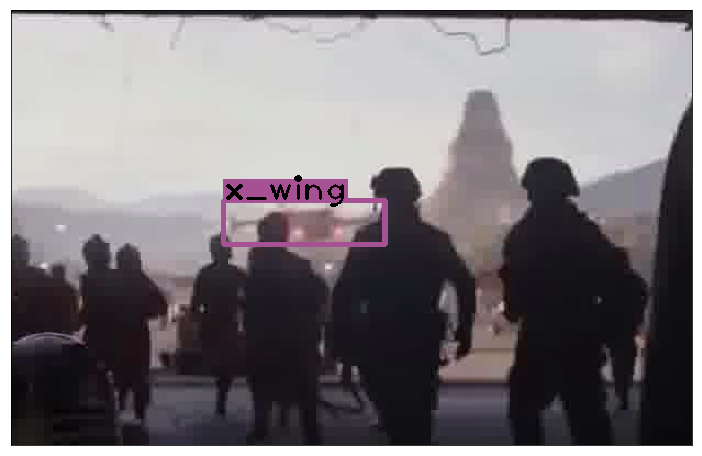

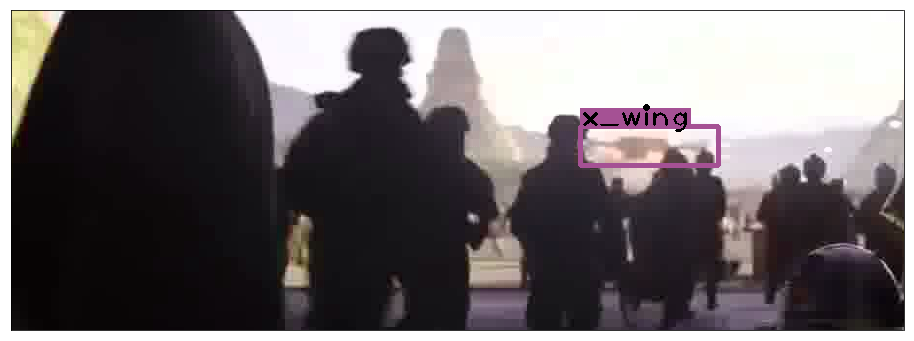

In [17]:
test_dataset(train_dl, output_dir, classes_names)

In [64]:
d = { 'sdsd': None, 'aaa': 4, 'sdfs':'fffff'}

In [65]:
{k:v for k,v in d.items() if v}

{'aaa': 4, 'sdfs': 'fffff'}